## **Regression by pycaret**

【公式】 Regression  
https://pycaret.readthedocs.io/en/latest/api/regression.html  

Setting up Environment  
https://pycaret.org/setup/  

pycaret/examples/  
https://github.com/pycaret/pycaret/tree/master/examples  

#### **Google Colaboratoyの環境確認/設定**

In [38]:
!df -h | grep -v -e tmp -e shm

Filesystem      Size  Used Avail Use% Mounted on
overlay         148G   40G  109G  27% /
/dev/sda1       154G   43G  111G  28% /opt/bin


In [1]:
# Linuxの環境確認
!cat /etc/issue 
!uname -a
!cat /proc/cpuinfo | grep 'model name'
!cat /proc/meminfo | grep Mem | awk '{print $1 " " $2/1024/1024 " GB"}'
!df -h | grep -v -e tmp -e shm
!cat /proc/uptime  | awk '{print $1/60/60 "hours (" $1 "sec)"}'
!nvidia-smi

# pycaret関連
! pip install -U pycaret[full]
#! pip install scikit-optimize # for tune by Bayesian search
#! pip install optuna          # for tune by TPE

Ubuntu 18.04.5 LTS \n \l

Linux 0d78b00d887e 5.4.104+ #1 SMP Sat Jun 5 09:50:34 PDT 2021 x86_64 x86_64 x86_64 GNU/Linux
model name	: Intel(R) Xeon(R) CPU @ 2.20GHz
model name	: Intel(R) Xeon(R) CPU @ 2.20GHz
MemTotal: 12.6867 GB
MemFree: 3.86018 GB
MemAvailable: 11.855 GB
1.92341hours (6924.29sec)
Thu Aug 12 07:04:15 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P0    29W / 25

### **ライブラリの読み込み**

In [2]:
import sys
print(sys.version)   # 3.7.11 (default, Jul  3 2021, 18:01:19) 
import math
import random
import copy
import os
import statistics as stat
from pprint   import pprint
from datetime import datetime, timedelta, timezone
JST = timezone(timedelta(hours=+9), 'JST')
start0 = datetime.now(JST)
print(f'now: {start0.strftime("%F %T")}')   # now: 2021-08-11 00:37:52

import numpy  as np
import pandas as pd
# pandas表示設定値の変更
pd.set_option('display.width',      100)
pd.set_option('display.precision',    4)
pd.set_option('display.max_rows',    20)
pd.set_option('display.max_columns', 12)

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
color = sns.color_palette()
sns.set_style('darkgrid')

from scipy import stats
from scipy.stats import norm, skew #for some statistics

# metrix for Classificaqtion
import sklearn 
from sklearn.metrics import confusion_matrix     # 混同行列
from sklearn.metrics import classification_report
# metrix for  regression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import pycaret
from pycaret.regression import *

import xgboost
import lightgbm

#バージョン確認
print(f'Module\'s Version; ',
      f'pycaret: {pycaret.__version__} sklearn: {sklearn.__version__}',
      f'xgboost: {xgboost.__version__} lightgbm: {lightgbm.__version__}')
# Module's Version;  pycaret: 2.3.3 sklearn: 0.23.2 xgboost: 1.4.2 lightgbm: 3.2.1

3.7.11 (default, Jul  3 2021, 18:01:19) 
[GCC 7.5.0]
now: 2021-08-12 16:04:21
Module's Version;  pycaret: 2.3.3 sklearn: 0.23.2 xgboost: 1.4.2 lightgbm: 3.2.1


#### **自作関数**

In [3]:
### Functions =================================================================
def xdescribe(df):   # pandas.describeメソッドの拡張 
    print(f'## Shape:{df.shape}')
    dtype    = pd.DataFrame({'dtype' : df.dtypes        })
    n_na     = pd.DataFrame({'NAs'   : df.isnull().sum()})
    n_unique = pd.DataFrame({'n_unique': [len(df[c].unique()) for c in df.columns]},
                            index=df.columns)
    df = df.describe(include='all').T
    if 'unique' in df.columns:
        df = df.drop(['unique'], axis=1)
    df = pd.concat([dtype, n_na, n_unique, df], axis=1)
    df['count'] = df['count'].astype(int)

    # backup & restore sttting
    mr = pd.get_option('display.max_rows')  # backup sttting
    pd.set_option('display.max_rows', None) # unlimitted
    display(df)
    pd.set_option('display.max_rows', mr)   # restore sttting

    return

### **データの取得・確認**

pycaretに含まれているbostonデータを使用  

各変数の属性の確認  
目的変数の分布を確認 => 正規分布からはあまり外れていないように見える  


,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
0,0.0063,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.0273,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.0273,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.0324,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.0691,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


Shapes; train:(405, 14), test(101, 14)

## 変数の確認
## Shape:(405, 14)


,dtype,NAs,n_unique,count,mean,std,min,25%,50%,75%,max
crim,float64,0,404,405,3.5869,8.5157,0.0063,0.0819,0.2498,3.6782,88.9762
zn,float64,0,25,405,11.6469,23.6735,0.0000,0.0000,0.0000,12.5000,100.0000
indus,float64,0,71,405,11.0231,6.8092,0.7400,5.1300,8.5600,18.1000,27.7400
chas,int64,0,2,405,0.0691,0.2540,0.0000,0.0000,0.0000,0.0000,1.0000
nox,float64,0,77,405,0.5538,0.1143,0.3850,0.4530,0.5320,0.6240,0.8710
rm,float64,0,370,405,6.3111,0.6976,3.5610,5.8980,6.2450,6.6300,8.7800
age,float64,0,293,405,68.3588,28.1897,2.9000,42.8000,76.9000,94.1000,100.0000
dis,float64,0,336,405,3.7833,2.0936,1.1296,2.1069,3.1827,5.1167,12.1265
rad,int64,0,9,405,9.6173,8.7515,1.0000,4.0000,5.0000,24.0000,24.0000
tax,int64,0,62,405,409.0568,168.1283,187.0000,279.0000,334.0000,666.0000,711.0000



## 目的変数の分布を確認

 mu = 22.65 and sigma = 9.13


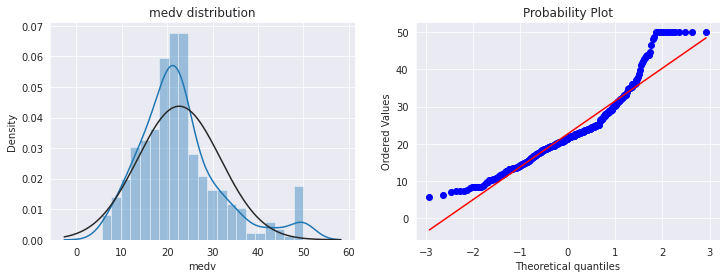

In [4]:
from pycaret.datasets import get_data
boston = get_data('boston')
target_colname = 'medv'

df_train = boston.sample(frac=0.8, random_state=1) # Train, valid
df_test  = boston.drop(df_train.index)             # Test(Predict)
 
df_train.reset_index(drop=True, inplace=True)
df_test.reset_index( drop=True, inplace=True)
print(f'Shapes; train:{df_train.shape}, test{df_test.shape}')

print(f'\n## 変数の確認') 
xdescribe(df_train)


### Target Variable

print(f'\n## 目的変数の分布を確認') 
# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(df_train[target_colname])
print( f'\n mu = {mu:.2f} and sigma = {sigma:.2f}')

#plot the distribution
fig = plt.figure(figsize=(12,4))
ax = fig.add_subplot(1, 2, 1)
ax.set_title(target_colname+' distribution')
sns.distplot(df_train[target_colname], fit=norm)

ax = fig.add_subplot(1, 2, 2)
stats.probplot(df_train[target_colname], plot=plt) #Q-Q plot
plt.show()

### **データセット、学習に関する設定 (setup)**

In [5]:
exp1 = setup(
    df_train,                 # 学習対象のデータセット
    target = target_colname,  # 目的変数
    train_size = 0.8,         # 学習で使うデータの割合
    transform_target = False, # 目的変数の対数変換 => 今回は行わない
#    data_split_stratify=True, fold_strategy='stratifiedkfold', # 連続値には適用できない?
    fold_shuffle = True,
    session_id = 0,           # random seed
    n_jobs = -1,
    use_gpu = True, 
    ignore_features = None,   # 学習に使用しない項目名
    silent = True             # 項目属性の自動判別結果の確認を抑制
)

,Description,Value
0,session_id,0
1,Target,medv
2,Original Data,"(405, 14)"
3,Missing Values,False
4,Numeric Features,11
5,Categorical Features,2
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(324, 21)"


### **モデルの比較 (compare_models)**


利用可能なすべてのモデルで学習し、結果を比較

In [34]:
top8_models = compare_models( # 後のアンサンブル学習で利用するため、各モデルの上位8モデルを保存
    sort = 'r2', 
    n_select = 8,    # 上位8モデルをreturn
    verbose = False
)
compare_models_score = pull() # 学習結果の取得
display(compare_models_score)

# 結果集約用データフレームの作成
col_names = ['Desc'] + compare_models_score.columns.values.tolist()
all_model_score = compare_models_score[0:8]
all_model_score['Desc']  = 'Base'
all_model_score['Model'] = all_model_score.index
all_model_score = all_model_score.reindex(columns=col_names).reset_index(drop=True)
display(all_model_score)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
catboost,CatBoost Regressor,1.9660,8.0933,2.7909,0.8920,0.1278,0.0982,1.775
et,Extra Trees Regressor,2.0383,8.4878,2.8509,0.8886,0.1231,0.1002,0.680
lightgbm,Light Gradient Boosting Machine,2.1878,10.2922,3.1037,0.8617,0.1345,0.1065,0.033
xgboost,Extreme Gradient Boosting,2.2954,10.7017,3.1483,0.8555,0.1384,0.1133,0.555
gbr,Gradient Boosting Regressor,2.2583,10.7652,3.1345,0.8514,0.1357,0.1092,0.099
rf,Random Forest Regressor,2.2944,12.5017,3.3508,0.8430,0.1412,0.1121,0.750
ada,AdaBoost Regressor,2.7310,13.4723,3.5657,0.8138,0.1597,0.1383,0.098
dt,Decision Tree Regressor,2.8399,18.5116,4.0935,0.7700,0.1724,0.1355,0.009
lr,Linear Regression,3.3864,23.6719,4.7265,0.6735,0.2595,0.1696,0.007
ridge,Ridge Regression,3.3903,23.8238,4.7375,0.6693,0.2566,0.1711,0.010


,Desc,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
0,Base,catboost,1.9660,8.0933,2.7909,0.8920,0.1278,0.0982,1.775
1,Base,et,2.0383,8.4878,2.8509,0.8886,0.1231,0.1002,0.680
2,Base,lightgbm,2.1878,10.2922,3.1037,0.8617,0.1345,0.1065,0.033
3,Base,xgboost,2.2954,10.7017,3.1483,0.8555,0.1384,0.1133,0.555
4,Base,gbr,2.2583,10.7652,3.1345,0.8514,0.1357,0.1092,0.099
5,Base,rf,2.2944,12.5017,3.3508,0.8430,0.1412,0.1121,0.750
6,Base,ada,2.7310,13.4723,3.5657,0.8138,0.1597,0.1383,0.098
7,Base,dt,2.8399,18.5116,4.0935,0.7700,0.1724,0.1355,0.009


### **モデルの選定、ハイパーパラメータチューニング**

チューニング探索方式(ライブラリ)を、OptunaのTPEを利用、探索回数を500と指定  
compare_modelsのR2値が、チューニングの結果改善  

In [33]:
# 上位8モデルのハイパーパラメータチューニングを実施
n_fold =  10 # cvのfold数: 指定しなければsetup()で指定した値(デフォルト:10)が使われる

# ハイパーパラメータチューニングの探索方式を設定
search_library   = 'optuna' # 'scikit-learn'(default) | 'scikit-optimize' | 'optuna' 
search_algorithm = 'tpe'    # 'random'|'grid'         | 'bayesian'        | 'random'|'tpe'
n_iter = 500 # ハイパーパラメータの探索回数

tuned_models = []
for i, model in enumerate(top8_models[0:8]):
    time_start = datetime.now(JST)
    model_name = top8_models_score.loc[i,"Model"]
    print(f'\n## Model Name: {model_name}')
    tuned_model = tune_model(
        model, 
        fold    = n_fold, 
        n_iter  = n_iter, 
        search_library   = search_library, 
        search_algorithm = search_algorithm,
        early_stopping = True,
        optimize = 'r2', 
        verbose=False
    )
    elapse = (datetime.now(JST)-time_start).total_seconds()
    tuned_models = tuned_models.append(tuned_model)
    model_score = pull()['Mean':'Mean']
    display(model_score)
    
    model_score = pd.concat([pd.Series({'Desc': 'Tuned_iter'+str(n_iter), 'Model': model_name}), 
                             model_score.iloc[0],
                             pd.Series({'TT (Sec)': elapse}),
                            ])
    #display(model_score)
    all_model_score = all_model_score.append(model_score, ignore_index=True)


print(f'\n## これまでのモデルの結果: {model_name}')
display(all_model_score)


## Model Name: catboost


Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already speci

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Mean,2.0382,8.0895,2.8074,0.89,0.1296,0.1024



## Model Name: et


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Mean,2.0502,8.1188,2.8009,0.8923,0.126,0.1026



## これまでのモデルの結果: et


,Desc,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
0,Base,catboost,1.9660,8.0933,2.7909,0.8920,0.1278,0.0982,1.6930
1,Base,et,2.0383,8.4878,2.8509,0.8886,0.1231,0.1002,0.6680
2,Base,lightgbm,2.1878,10.2922,3.1037,0.8617,0.1345,0.1065,0.0310
3,Base,xgboost,2.2954,10.7017,3.1483,0.8555,0.1384,0.1133,0.5280
4,Base,gbr,2.2583,10.7652,3.1345,0.8514,0.1357,0.1092,0.0910
5,Base,rf,2.2944,12.5017,3.3508,0.8430,0.1412,0.1121,0.7080
6,Base,ada,2.7310,13.4723,3.5657,0.8138,0.1597,0.1383,0.0910
7,Base,dt,2.8399,18.5116,4.0935,0.7700,0.1724,0.1355,0.0080
8,Tuned_iter100,catboost,2.0382,8.0895,2.8074,0.8900,0.1296,0.1024,1113.2809
9,Tuned_iter100,et,2.0502,8.1188,2.8009,0.8923,0.1260,0.1026,1344.9396


### **モデル分析・評価 (evaluate models)**

参考：Pycaretの回帰・分類で出力されるグラフの種類について解説　　
https://qiita.com/ground0state/items/57e565b23770e5a323e9

In [8]:
# 学習結果の確認
evaluate_model(tuned_model)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

#### **個別にプロットする場合**

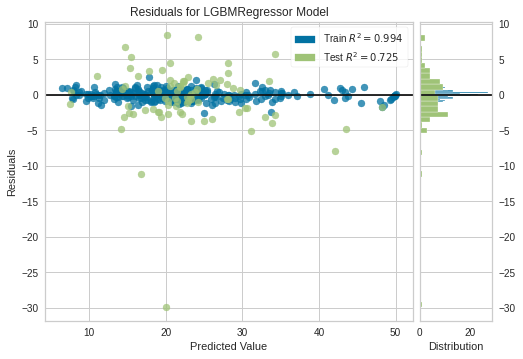

In [9]:
plot_model(tuned_model, plot='residuals') # 残差プロット

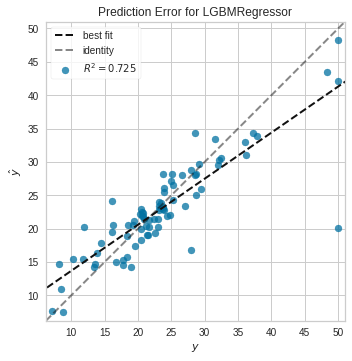

In [10]:
plot_model(tuned_model, plot='error') # 誤差(true-pred)プロット

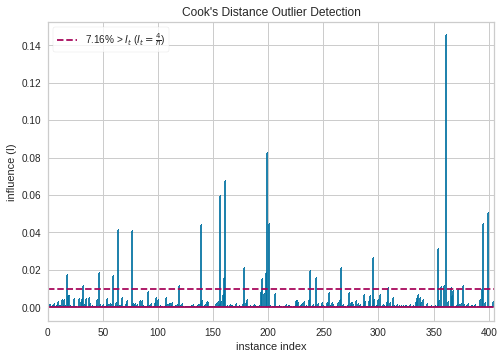

In [11]:
plot_model(tuned_model, plot='cooks') # クックの距離

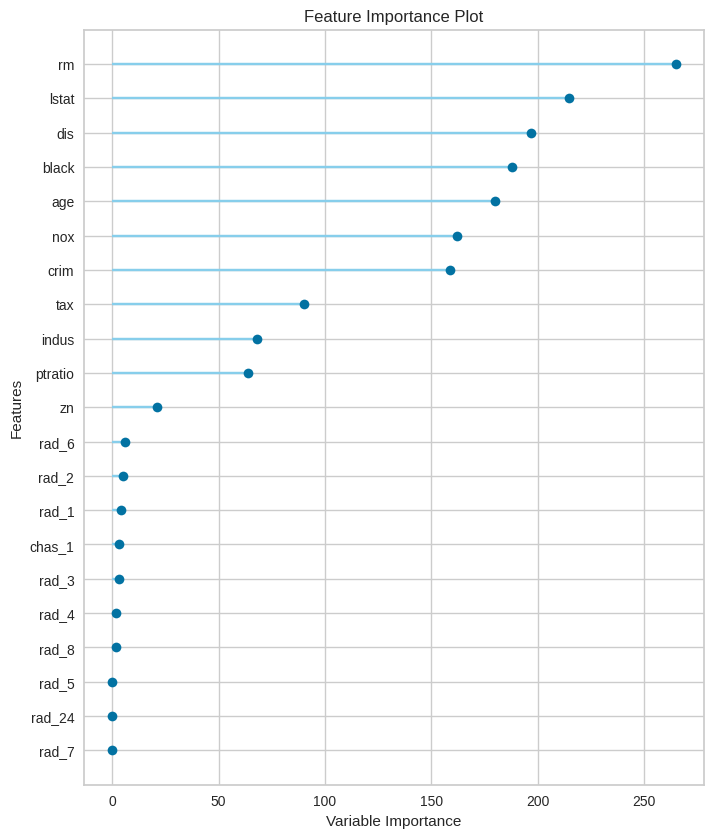

In [12]:
plot_model(tuned_model, plot='feature_all') # 特徴量の重要度

### **モデルのファイナライズ (finalize_model)、予測 (predict_model)**

モデルをファイナライズして最初に分離したテストデータセットに対して予測を実施  
R2値が0.90688とかなり良くなっている

In [13]:
final_model = finalize_model(tuned_model)
print(final_model)

pred_test = predict_model(final_model, data=df_test)
display(pred_test)
print(f'\n### Score: R2: {r2_score(df_test[target_colname], pred_test["Label"]):.5f},',
      f'RMSE: {mean_absolute_error(df_test[target_colname], pred_test["Label"]):.5f}',
      f'\n')

[LightGBM] [Warning] feature_fraction is set=0.5171022599630236, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5171022599630236
[LightGBM] [Warning] bagging_fraction is set=0.9733089977275777, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9733089977275777
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=0.5171022599630236, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5171022599630236
[LightGBM] [Warning] bagging_fraction is set=0.9733089977275777, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9733089977275777
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=0.5171022599630236, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5171022599630236
[LightGBM] [Warning] bagging

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv,Label
0,0.0273,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6,20.8768
1,0.0324,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4,36.5263
2,0.1446,12.5,7.87,0,0.524,6.172,96.1,5.9505,5,311,15.2,396.90,19.15,27.1,17.9350
3,0.6274,0.0,8.14,0,0.538,5.834,56.5,4.4986,4,307,21.0,395.62,8.47,19.9,20.4933
4,1.2325,0.0,8.14,0,0.538,6.142,91.7,3.9769,4,307,21.0,396.90,18.72,15.2,15.4916
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,4.0384,0.0,18.10,0,0.532,6.229,90.7,3.0993,24,666,20.2,395.33,12.87,19.6,21.8098
97,0.1834,0.0,27.74,0,0.609,5.414,98.3,1.7554,4,711,20.1,344.05,23.97,7.0,12.0212
98,0.1113,0.0,27.74,0,0.609,5.983,83.5,2.1099,4,711,20.1,396.90,13.35,20.1,18.9652
99,0.2896,0.0,9.69,0,0.585,5.390,72.9,2.7986,6,391,19.2,396.90,21.14,19.7,18.3269



### Score: R2: 0.90688, RMSE: 1.91472 



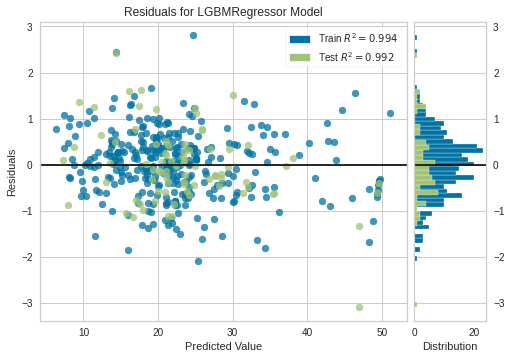

In [14]:
plot_model(final_model, plot='residuals')

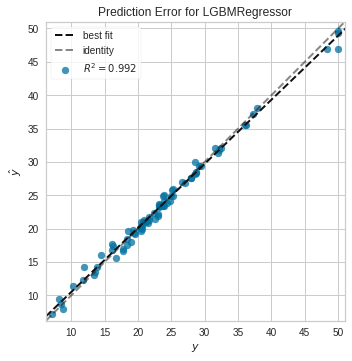

In [15]:
plot_model(final_model, plot='error')

### **結果の出力**

今回はsubmission対象でないので出力しない

In [16]:
# 結果の出力 (今回はsubmission対象でないので出力しない)
# pred_test[['Label']].to_csv('pred_test_label.csv', index=True, header=True)

### **アンサンブルもやってみる**

#### **Blend Models**


```
|ブレンドモデル数|チューニング|結果(R2)|
|----------------|------------|--------|
|              3 |    なし    | 0.8935 |
|              3 |    あり    | 0.8968 |
|              6 |    なし    | 0.8824 |
```

In [18]:
display(top8_models_score[0:5])
blended_top3_model = blend_models(top8_models[0:3], optimize='r2', verbose=False)

brend_top3_models_score = pull() # 学習結果の取得
print(f'\n## 上位3モデルのブレンド結果')
display(brend_top3_models_score['Mean':'Mean'])
print(f'\n## モデル:\n{blended_top3_model}')

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
catboost,CatBoost Regressor,1.9660,8.0933,2.7909,0.8920,0.1278,0.0982,1.719
et,Extra Trees Regressor,2.0383,8.4878,2.8509,0.8886,0.1231,0.1002,0.729
lightgbm,Light Gradient Boosting Machine,2.1878,10.2922,3.1037,0.8617,0.1345,0.1065,0.032
xgboost,Extreme Gradient Boosting,2.2888,10.6895,3.1459,0.8557,0.1383,0.1130,0.840
gbr,Gradient Boosting Regressor,2.2583,10.7652,3.1345,0.8514,0.1357,0.1092,0.103



## 上位3モデルのブレンド結果


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Mean,1.9755,8.1466,2.7808,0.8935,0.1221,0.0971


In [17]:
display(top8_models_score[0:8])
blended_top6_model = blend_models(top8_models[0:6], optimize='r2', verbose=False)

brend_top6_models_score = pull() # 学習結果の取得
print(f'\n## 上位6モデルのブレンド結果')
display(brend_top6_models_score['Mean':'Mean'])

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
catboost,CatBoost Regressor,1.9660,8.0933,2.7909,0.8920,0.1278,0.0982,1.719
et,Extra Trees Regressor,2.0383,8.4878,2.8509,0.8886,0.1231,0.1002,0.729
lightgbm,Light Gradient Boosting Machine,2.1878,10.2922,3.1037,0.8617,0.1345,0.1065,0.032
xgboost,Extreme Gradient Boosting,2.2888,10.6895,3.1459,0.8557,0.1383,0.1130,0.840
gbr,Gradient Boosting Regressor,2.2583,10.7652,3.1345,0.8514,0.1357,0.1092,0.103
rf,Random Forest Regressor,2.2944,12.5017,3.3508,0.8430,0.1412,0.1121,0.769
ada,AdaBoost Regressor,2.7310,13.4723,3.5657,0.8138,0.1597,0.1383,0.100
dt,Decision Tree Regressor,2.8399,18.5116,4.0935,0.7700,0.1724,0.1355,0.009



## 上位6モデルのブレンド結果


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Mean,2.0623,8.9472,2.8913,0.8824,0.1256,0.1009


In [26]:
search_library   = 'optuna' # 'scikit-learn'(default) | 'scikit-optimize' | 'optuna' 
search_algorithm = 'tpe'    # 'random'|'grid'         | 'bayesian'        | 'random'|'tpe'
n_iter = 500                # ハイパーパラメータの探索回数

blended_top3_model = blend_models([tune_model(m, optimize='r2', n_iter=n_iter, 
                                              search_library=search_library, search_algorithm=search_algorithm, 
                                              early_stopping=True, verbose=False)
                                                                                    for m in  top8_models[0:3]], 
                                  optimize='r2', verbose=False)

brend_top3_models_score = pull() # 学習結果の取得
print(f'\n## チューニングされた上位3モデルのブレンド結果')
display(brend_top3_models_score['Mean':'Mean'])

Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already speci

[LightGBM] [Warning] feature_fraction is set=0.5864520049217872, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5864520049217872
[LightGBM] [Warning] bagging_fraction is set=0.7843495431897185, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7843495431897185
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.5864520049217872, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5864520049217872
[LightGBM] [Warning] bagging_fraction is set=0.7843495431897185, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7843495431897185
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.5864520049217872, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5864520049217872
[LightGBM] [Warning] bagging

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Mean,1.9666,7.8576,2.7342,0.8968,0.1224,0.0983


#### **Stack Models**

In [20]:
display(top8_models_score[0:5])
#stacked_model = stack_models(top8_models[0:3], optimize='r2', verbose=False)
stacked_model = stack_models(top8_models[0:3], meta_model=top8_models[3], optimize='r2', verbose=False)

stack_top3_model_score = pull() # 学習結果の取得
print(f'\n## 上位3モデルのスタック結果')
display(stack_top3_model_score['Mean':'Mean'])

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
catboost,CatBoost Regressor,1.9660,8.0933,2.7909,0.8920,0.1278,0.0982,1.719
et,Extra Trees Regressor,2.0383,8.4878,2.8509,0.8886,0.1231,0.1002,0.729
lightgbm,Light Gradient Boosting Machine,2.1878,10.2922,3.1037,0.8617,0.1345,0.1065,0.032
xgboost,Extreme Gradient Boosting,2.2888,10.6895,3.1459,0.8557,0.1383,0.1130,0.840
gbr,Gradient Boosting Regressor,2.2583,10.7652,3.1345,0.8514,0.1357,0.1092,0.103



## 上位3モデルのスタック結果


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Mean,2.1853,9.4961,2.9871,0.8729,0.1369,0.1063


In [22]:
display(top8_models_score[0:8])
stacked_model = stack_models(top8_models[0:6], meta_model=top8_models[6], optimize='r2', verbose=False)

stack_top6_model_score = pull() # 学習結果の取得
print(f'\n## 上位6モデルのスタック結果')
display(stack_top6_model_score['Mean':'Mean'])

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
catboost,CatBoost Regressor,1.9660,8.0933,2.7909,0.8920,0.1278,0.0982,1.719
et,Extra Trees Regressor,2.0383,8.4878,2.8509,0.8886,0.1231,0.1002,0.729
lightgbm,Light Gradient Boosting Machine,2.1878,10.2922,3.1037,0.8617,0.1345,0.1065,0.032
xgboost,Extreme Gradient Boosting,2.2888,10.6895,3.1459,0.8557,0.1383,0.1130,0.840
gbr,Gradient Boosting Regressor,2.2583,10.7652,3.1345,0.8514,0.1357,0.1092,0.103
rf,Random Forest Regressor,2.2944,12.5017,3.3508,0.8430,0.1412,0.1121,0.769
ada,AdaBoost Regressor,2.7310,13.4723,3.5657,0.8138,0.1597,0.1383,0.100
dt,Decision Tree Regressor,2.8399,18.5116,4.0935,0.7700,0.1724,0.1355,0.009



## 上位6モデルのスタック結果


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Mean,2.2284,10.307,3.0508,0.8644,0.1327,0.1102


In [24]:
best_model = automl(optimize='r2')
best_model

VotingRegressor(estimators=[('catboost',
                             <catboost.core.CatBoostRegressor object at 0x7fe708c92d10>),
                            ('et',
                             ExtraTreesRegressor(bootstrap=False, ccp_alpha=0.0,
                                                 criterion='mse',
                                                 max_depth=None,
                                                 max_features='auto',
                                                 max_leaf_nodes=None,
                                                 max_samples=None,
                                                 min_impurity_decrease=0.0,
                                                 min_impurity_split=None,
                                                 min_samples_leaf=1,
                                                 min_samples_split=2,
                                                 min_weight_fraction_...
                                           class_weig

### **目的変数の対数変換**

上記では目的変数を対数変換しなかったが、対数変換も試してみる  
transform_target = True

In [ ]:
exp1 = setup(
    df_train,                # 学習対象のデータセット
    target = target_colname, # 目的変数
    train_size = 0.8,        # 学習で使うデータの割合
    transform_target = True, # 目的変数の対数変換        <<=== 変更
    fold_shuffle = True,
    session_id = 0,          # random seed
    n_jobs = -1,
    ignore_features = None,  # 学習に使用しない項目名
    silent = True            # 項目属性の自動判別結果の確認を抑制
)
compare_models(sort = 'r2')

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
et,Extra Trees Regressor,2.0580,8.1985,2.8093,0.8922,0.1202,0.0990,0.347
catboost,CatBoost Regressor,1.9751,8.6210,2.8617,0.8862,0.1252,0.0956,2.797
gbr,Gradient Boosting Regressor,2.1916,10.0495,3.0647,0.8645,0.1308,0.1041,0.102
lightgbm,Light Gradient Boosting Machine,2.2296,11.3406,3.2295,0.8507,0.1355,0.1058,0.041
xgboost,Extreme Gradient Boosting,2.3198,12.4808,3.3805,0.8355,0.1391,0.1114,1.994
rf,Random Forest Regressor,2.3423,13.4545,3.4585,0.8297,0.1441,0.1121,0.413
ada,AdaBoost Regressor,2.6252,16.0376,3.8178,0.7980,0.1494,0.1195,0.112
ridge,Ridge Regression,2.9799,19.3877,4.2459,0.7471,0.1809,0.1391,0.020
lr,Linear Regression,3.0129,19.4752,4.2678,0.7453,0.1801,0.1398,0.029
br,Bayesian Ridge,3.0564,20.7423,4.4033,0.7314,0.1856,0.1418,0.020


PowerTransformedTargetRegressor(bootstrap=False, ccp_alpha=0.0, criterion='mse',
                                max_depth=None, max_features='auto',
                                max_leaf_nodes=None, max_samples=None,
                                min_impurity_decrease=0.0,
                                min_impurity_split=None, min_samples_leaf=1,
                                min_samples_split=2,
                                min_weight_fraction_leaf=0.0, n_estimators=100,
                                n_jobs=-1, oob_score=False,
                                power_transformer_method='box-cox',
                                powe...
                                regressor=ExtraTreesRegressor(bootstrap=False,
                                                              ccp_alpha=0.0,
                                                              criterion='mse',
                                                              max_depth=None,
                             